Groupe:

1 - Nom, Prénom, Matricule: Dinh, Huyen Trang, 1846776

2 - Nom, Prénom, Matricule: Ossim Belias, François Philippe, 1822601

L'objectif de ce laboratoire est de se familiariser avec les notions de segmentation et de manipulation d'images couleurs. Pour cela, nous allons transformer une photographie réelle afin de lui donner un effet dessin. Deux étapes sont mises en oeuvre: la première est de détecter les contours dans l'image, pour donner un effet trait au feutre noir à notre dessin. La seconde consiste à réduire intelligemment le nombre de couleurs, de telle sorte à obtenir des régions uniformes.


**Remise**: 

La date de remise est fixée au lundi 7 Décembre à 23h55. Une pénalité de 3 points par jour sera appliquée lors d'un retard.

**Documents à remettre** :


Les exercices doivent être codés dans ce fichier TP.ipynb. Les réponses aux questions doivent être inclues dans le code sous forme de commentaires ou dans des cellules dédiées (*Markdown* ou *text*). Les exercices doivent être séparés par des cellules, suivant le template fourni. Vous devez bien identifier chaque exercice et sous-question, et bien commenter le code. Veuillez nommer vos variables de manière explicite et assurez-vous que toutes les figures soient lisibles.

Créer un fichier de rendu **html** (*Fichier -> Télécharger au format... -> HTML*)  de votre code et de vos graphiques. Veuillez remettre tous vos fichiers (.ipynb, html et autres) dans un seul fichier **zip** et nommez ce fichier selon vos matricules (Mat1\_Mat2.zip).


Une pénalité de 3 points sera appliquée si ces consignes ne sont pas respectées.

# Imports et utilitaires

In [17]:
import cv2
import numpy as np
import scipy
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray' # Choix de la color map par défaut, ne pas modifier
import matplotlib
import scipy.signal
matplotlib.rcParams['figure.figsize'] = (25.0, 10.0) # Taille des figures par défaut, peut-être modifié au cas par cas.
from scipy.cluster.vq import kmeans

def imshow(img, title=None, ax=None, is_bgr=False, cmap='gray'):
    """
    param img: image à afficher (soit hxwx3, soit hxw)
    param title: Falcultatif. Titre du graphique
    param ax: Falcultatif. axe sur lequel l'image sera affiché. Si aucun n'est donné, un nouvel axe sera créé.
    param is_bgr: Pour une image couleur, si vraie, effectue la conversion BGR -> RGB
    param cmap: Map de couleur utilisé pour afficher les images.
    """
    show=False
    plt.axis('off')
    if ax is None:
        show=True
        if title is not None:
            plt.title(title)
        ax = plt
    else:
        if title is not None:
            ax.set_title(title)
            ax.set_axis_off()
    
    if img.ndim==2:
        ax.imshow(img, cmap='gray')
    else:
        if is_bgr:
            img = img[:,:,::-1].copy()
        ax.imshow(img)
    if show:
        plt.show()

def f2int(img):
    return (img*255).astype(np.uint8)

def int2f(img):
    return img.astype(np.float32)/255.

# Partie 1
Qui dit dessin dit traits. La première partie de ce TP sera donc consacrée à la détection des contours de l'image, que nous assimilerons par la suite à des traits faits au feutre dans notre dessin. Pour afficher les images, nous vous fournissons une fonction **imshow** (voir la cellule ci-dessus) que vous pouvez utiliser au choix.

## Question 1



Chargez l'image **chat.png**, convertissez-la en valeurs flottantes et affichez-la.



Assurez-vous que les couleurs soient correctement rendues (i.e: telles qu'elles apparaissent dans votre navigateur d'image) et que tous les pixels soient compris dans l'intervalle [0,1].

> **Attention** Si vous utilisez **openCV** (cv2), la librairie ordonne les canaux dans l'ordre <span style="color:blue">b</span>, <span style="color:green">v</span>, <span style="color:red">r</span> au lieu du conventionnel <span style="color:red">r</span>, <span style="color:green">v</span>, <span style="color:blue">b</span>.

> Dans la majeure partie du TP, nous travaillerons avec des valeurs de pixels comprises entre 0 et 1 pour des images de type **np.float32**. Certaines fonctions spécifiques attendent cependant des valeurs comprises entre 0 et 255, pour des images de type np.uint8. Pour vous faciliter le travail, nous fournissons deux fonctions **f2int** et **int2f** qui se chargeront de faire la conversion d'un type vers l'autre (voir cellule de code ci-dessus).


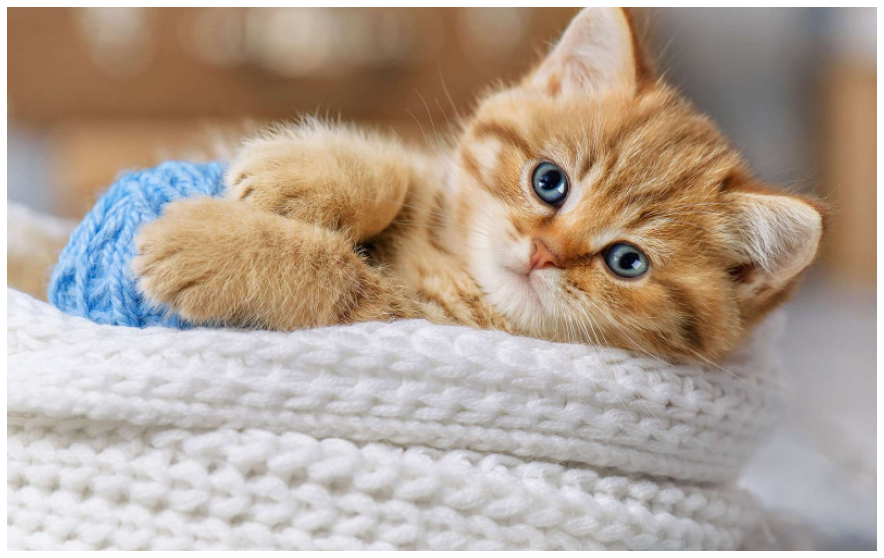

In [18]:
img = cv2.imread("chaton.png")
img = int2f(img)
imshow(img, is_bgr=True)

## Question 2
La clarté d'une image est définie par:
$$
c = \frac{1}{2}(\max(r, v, b) + \min(r, v, b))
$$

Calculez la clarté de l'image et affichez-la.

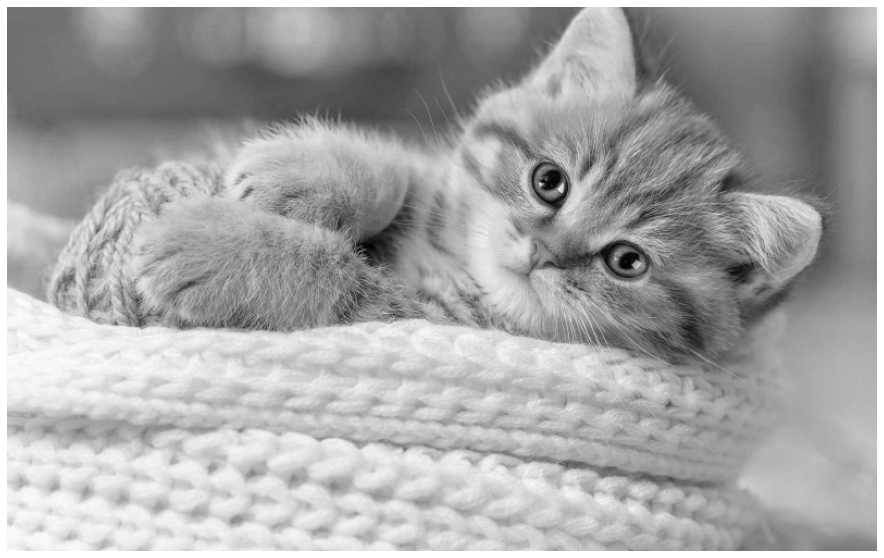

In [93]:
def clarte(img):
    clarte = np.zeros(img.shape[0:2])
    clarte = 0.5 * (np.max(img, axis=2) + np.min(img, axis=2))
    return clarte

clarte = clarte(img)
imshow(clarte)

## Question 3
Dans la suite du TP, nous essayerons de détecter les contours dans l'image. Les différentes méthodes vues en cours ont tendance à être sensibles. Or, dans le cas présent le pelage du chat peut-être assimilé à un bruit poivre et sel dense. Quel type de filtre faut-il utiliser pour l'atténuer? Filtrez la clarté avec ce filtre en utilisant une fenêtre de taille 7. 

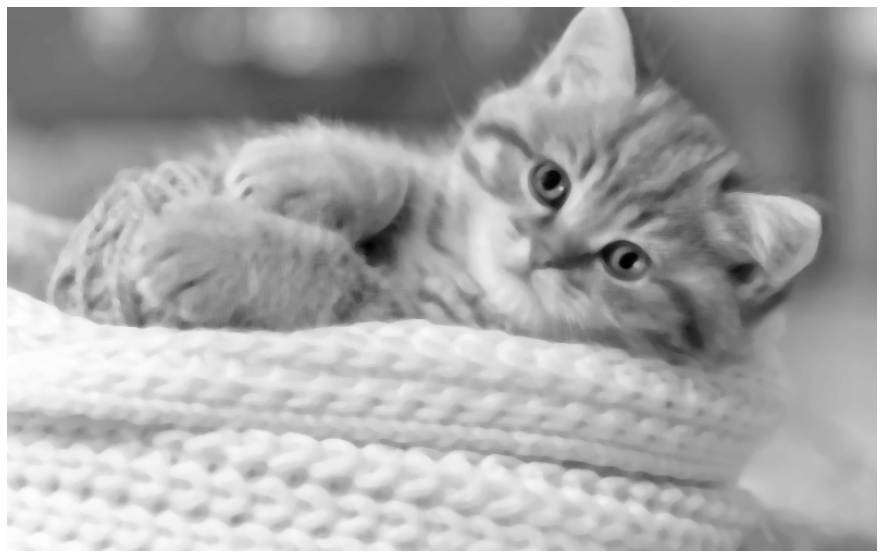

In [95]:
clarte_filtree = cv2.medianBlur(f2int(clarte), 7)
imshow(clarte_filtree, is_bgr=True)


**Important** Pour les prochaines questions, nous allons comparer différentes techniques de détection des contours. Pour cela, nous partirons de l'image de clarté filtrée à la question précédente dans toutes les questions suivantes.

# Question 4

Calculez et affichez sur deux graphiques adjacent (subplots):
- L'image du gradient horizontal
- L'image du gradient vertical

Sur un troisième graphique (nouvelle figure), affichez également la magnitude du gradient.

> Pour calculer les gradients, vous devez définir vous-mêmes les masques de convolution. Pour la convolution en elle-même, utilisez la fonction **scipy.signal.convolve2d**
```python
convolved = scipy.signal.convolve2d(img, mask, mode='same')
```

In [125]:
def afficherGradients(convolved_x, convolved_y, magnitude_gradient):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    imshow(convolved_x, title="Gradient horizontal", ax=ax1)
    imshow(convolved_y, title="Gradient vertical", ax=ax2)
    imshow(magnitude_gradient, title="Magnitude du gradient", ax=ax3)
    
def calculerGradients(image):
    g_x = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]]) #prewitt
    g_y = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]]) #prewitt

    convolved_x = scipy.signal.convolve2d(image, g_x, mode='same')
    convolved_y = scipy.signal.convolve2d(image, g_y, mode='same')
    magnitude_gradient = np.sqrt(convolved_x ** 2 + convolved_y ** 2)

    return convolved_x, convolved_y, magnitude_gradient


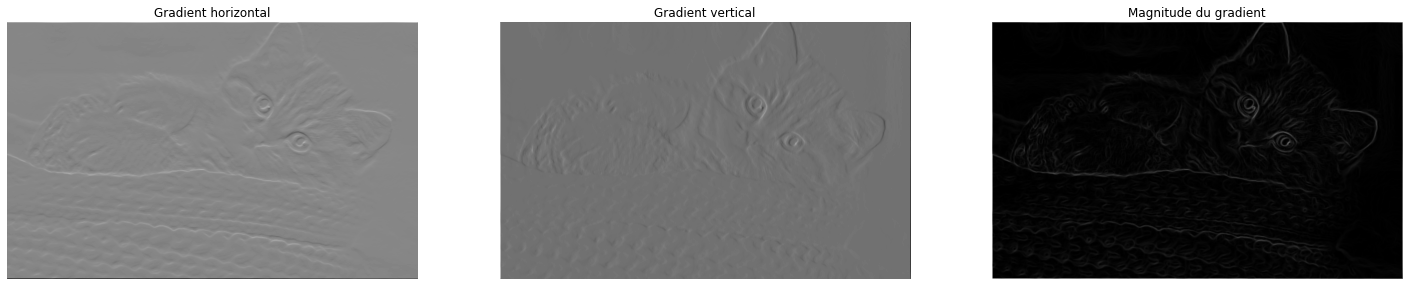

In [127]:
convolved_x, convolved_y, magnitude_gradient = calculerGradients(clarte_filtree)
afficherGradients(convolved_x, convolved_y, magnitude_gradient)

# Question 5

Refaites la même expérience, mais cette fois en préfiltrant l'image avec un filtre Gaussien d'écart-type $\sigma=1$. Vous devez construire vous-même le masque Gaussien (vous ne pouvez pas utiliser cv2.GaussianBlur), en justifiant la taille du masque (en fonction de $\sigma$).
Que se passe-t-il lorsqu'on fait varier sigma?

> On rappelle qu'une fonction Gaussienne 2D est donnée par 
$$G(x, y)=A e^{\frac{-(x²+y²)}{2\sigma²}}$$
où $A$ est une constante permettant d'assurer que l'aire sous la gaussienne est bien égale à 1.

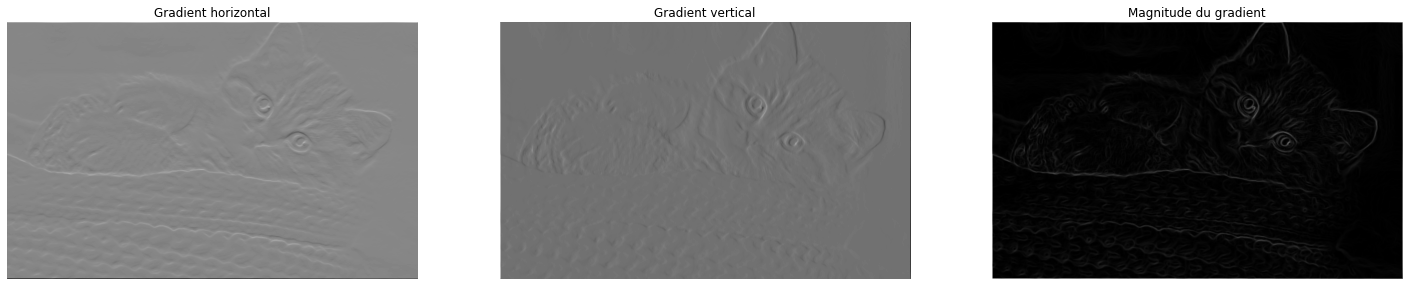

In [137]:
def gaussian2d(sigma):
    kernel_size = int(6 * sigma)
    x, y = np.meshgrid(np.linspace(-1,1,kernel_size), np.linspace(-1,1,kernel_size))
    gauss = np.exp(-(x**2 + y**2) / 2* sigma ** 2)
    A =  1 / np.sum(gauss)
    return A * gauss


sigma = 1
gaussian_mask = gaussian2d(sigma)

clarte_gaussien = scipy.signal.convolve2d(clarte_filtree, gaussian_mask, mode='same')

convolved_x, convolved_y, magnitude_gradient = calculerGradients(clarte_gaussien)
afficherGradients(convolved_x, convolved_y, magnitude_gradient)


# Question 6
Afin d'extraire des contours de la magnitude des gradients, nous allons utiliser la méthode d'Otsu que vous allez devoir implémenter.
Complétez la fonction suivante:
```python
def seuillage_otsu(img):
    assert img.dtype==np.uint8, "L'image doit être de type uint8"
    thresholds = np.unique(img)
    hist, bins = np.histogram(img, np.arange(256))
    bins = bins[:-1]
    hist = hist/img.size
    nu = 0
    for k in thresholds:
        hist_c1  = hist[:k] # Histogramme du cluster 1
        hist_c2  = hist[k:] # Histogramme du cluster 2
        P1_k = ... # Probabilité d'appartenir au cluster 1
        P2_k = ... # A compléter
        if P1_k==0:
            continue
        if P2_k==0:
            break
        m1_k =  np.sum(bins[:k]*hist_c1) / P1_k.astype(np.float32) # Calcul de la moyenne sur le cluster 1
        m2_k =  ... # A compléter
        var_interclasse = ... # A compléter
        if var_interclasse>nu:
            threshold = k
            nu = var_interclasse
    image_seuillee = ... # À completer
    return image_seuillee
```
Qui prend une image monochrome en paramètre et effectue un seuillage automatique selon la méthode d'Otsu. 

> Attention, pour la méthode d'Otsu, l'image doit-être de type uint8.

Comparez l'effet de la fonction sur la magnitude de gradients avec préfiltrage gaussien et sans. Qu'observez-vous?

In [144]:
def seuillage_otsu(blur):
    hist = cv2.calcHist([blur],[0],None,[256],[0,256])
    hist_norm = hist.ravel()/hist.max()
    Q = hist_norm.cumsum()

    bins = np.arange(256)

    fn_min = np.inf
    thresh = -1

    for i in range(1,256):
        p1,p2 = np.hsplit(hist_norm,[i]) # probabilities
        q1,q2 = Q[i],Q[255]-Q[i] # cum sum of classes
        b1,b2 = np.hsplit(bins,[i]) # weights

        # finding means and variances
        m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
        v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2

        # calculates the minimization function
        fn = v1*q1 + v2*q2
        if fn < fn_min:
            fn_min = fn
            thresh = i

    # find otsu's threshold value with OpenCV function
    ret, otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return ret, otsu

In [146]:
seuillage_otsu(clarte_filtree.astype("uint8"))

<ipython-input-144-0685f7a3637e>:17: RuntimeWarning: invalid value encountered in double_scalars
  m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
<ipython-input-144-0685f7a3637e>:17: RuntimeWarning: divide by zero encountered in double_scalars
  m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
<ipython-input-144-0685f7a3637e>:18: RuntimeWarning: invalid value encountered in multiply
  v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2


(159.0, array([[  0,   0,   0, ..., 255, 255, 255],
        [  0,   0,   0, ..., 255, 255, 255],
        [  0,   0,   0, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0]], dtype=uint8))

## Question 7
Vous allez maintenant expérimenter la détection de contours par la méthode de Marr-Hildreth. On rappelle les étapes de la méthode:
* L'image est filtrée avec une gaussienne (fixée par $\sigma$)
* On calcule son Laplacien
* On cherche les passages par zéros du Laplacien. On conserve ceux correspondant à un écart absolu supérieur à un seuil $t<1$

> Le code de la fonction cherchant les passages par zéros vous est fourni. Elle attend en paramètre une image Laplacien et un seuil. 


Affichez les contours pour $\sigma=5$ et un seuil égal à 0.005. Pour le calcul du Laplacien, vous devez créer vous-même le filtre correspondant.
Testez la détection des contours pour différentes valeurs de sigma et de seuil et indiquez l'effet de ces deux paramètres.

In [ ]:
def passage_par_zeros(img, seuil):
    out = np.zeros_like(img)
    for i in range(1, img.shape[0]-1):
        for j in range(1, img.shape[1]-1):
            ec = 0
            if img[i-1, j]*img[i+1, j] < 0: # y
                ec = max(ec, np.abs(img[i+1, j]-img[i-1, j]))
            if img[i, j-1]*img[i, j+1] < 0: # x
                ec = max(ec, np.abs(img[i, j+1]-img[i, j-1]))
            if img[i-1, j-1]*img[i+1, j+1] < 0: # diag
                ec = max(ec, np.abs(img[i+1, j+1]-img[i-1, j-1]))
            if img[i+1, j-1]*img[i-1, j+1] < 0: # other diag
                ec = max(ec, np.abs(img[i+1, j-1]-img[i-1, j+1]))
            
            out[i, j] = ec
    
    threshold = seuil*np.max(out)
    return out>threshold


## Question 8

Enfin, pour compléter votre tour d'horizon des méthodes de détection de contours, vous allez utiliser la méthode de Canny. L'implémentation n'est pas demandée: vous pouvez vous servir de la méthode d'**openCV** de la manière suivante:

```python
edges_canny = cv2.Canny(clarte, min_hysteresis, max_hysteresis) # clarte doit être en uint8
```
où min_hysteresis, max_hysteresis représentent respectivement les seuils bas et haut du filtrage par hystérésis.
En partant d'un seuil haut à 100, comparez l'effet de différentes valeurs de seuils bas et discutez du résultat.

## Question 9
Affichez sur un subplots 2x2 les contours obtenus (Otsu sur gradient sans gaussienne et avec gaussienne, avec la méthode de Marr-Hildreth et avec la méthode de Canny). Commentez leurs effets respectifs et leur flexibilité.


# Partie 2

Cette partie manipule les images couleurs. Repartez donc de l'image chargée à la toute première question de la partie 1

## Question 10
Chargez l'image **chat.png**, filtrez-la avec un filtrage médian de taille 9, convertissez-la en valeur flottantes et affichez-la. 

Une photographie contient beaucoup plus de couleurs qu'un dessin. Nous allons effectuer une opération de **postérisation** consistant à réduire le nombre de couleurs contenues dans une image. Nous allons pour cela comparer différentes approches.

### Postérisation naive

Pour cette méthode, on recense toutes les N couleurs distinctes contenues dans l'image sous la forme d'un tableau $T_1$ de taille $N\times 3$. Par la suite, on ne garde que les K couleurs les plus présentes dans l'image de telle sorte à obtenir un tableau $T_2$ de taille $K \times 3$. 

Pour chaque pixel de l'image originale, on remplace alors sa couleur par celle qui lui est la plus proche dans le tableau $T_2$. La notion de proximité est définie en utilisant la distance euclidienne.



## Question 11
Implémentez la fonction
```python 
def recenser_couleurs(img):
    ...
    return couleurs_uniques, comptes 

```
Qui renvoie un tableau de couleurs uniques dans une image ainsi que le nombre de pixels associé à chacune. 

## Question 12
Complétez les fonctions:

```python
def distance_euclienne(col1, col2):
    """
    Cette fonction prend en entrée deux tableaux de couleurs et renvoie le tableau des distances entre chacune d'entre elles
    :param col1: Tableau de taille Nx3
    :param col2: Tableau de taille Mx3
    :return d: Tableau des distances euclidiennes de taille NxM

    """
    ...
    return d

def posterisation_naive(img, K=32):
    h, w, c = img.shape
    col_uniques, comptes = recenser_couleurs(img)
    T2 = ... # A compléter: on ne garde que K les couleurs de col_uniques les + présentes
    distances = distance_euclienne(T2,  img.reshape(-1, c))
    indices_d_minimale = ... # On récupère pour chaque pixel l'indice qui va nous donner la nouvelle couleur dans T2.
    posterisation = ...
    return posterisation.reshape(h, w, c)
    
```

## Question 13
Testez et affichez le résultat de la fonction avec K=64. Qu'observez-vous et qu'en concluez-vous sur la postérisation naive?

## Question 14
Pour corriger les défauts de la postérisation naive, nous allons utiliser une manière plus sophistiquée de réduire le nombre de couleurs. Plutôt que ne garder que les plus présentes, nous allons regrouper chaque couleur en K paquets (appelés clusters) de telle sorte que chaque paquet contiennent les couleurs qui lui sont les plus proches. Notre nouveau tableau $T2$ sera alors constitué des moyennes de chaque paquet. Cet algorithme est appelé *K-moyennes* (K-mean) et il est fondamental en IA. 

Mais pas de panique, vous n'avez pas à l'implémenter! Vous pouvez simplement utiliser la version fournie par la librairie scipy:
```python
from scipy.cluster.vq import kmeans
T2 = kmeans(T1, K)[0] # K est le nombre de couleurs que l'on souhaite garder, T1 le tableau de couleurs uniques.
```

Implémentez la fonction
```python
def posterisation_kmeans(img, K=8):
    ...
```
De telle sorte à utiliser l'algorithme *kmeans* pour le calcul de T2. Affichez les résultats pour K=2,K=8 et K=64. Qu'en concluez-vous?

## Question 15

Dans les cas précédents, on a postérisé l'image sans considérations sur l'importance de certaines couleurs par rapport à d'autres. Cependant en général, sur un dessin, une palette de couleurs contient beaucoup plus de teintes différentes que de saturations ou d'intensités différentes (dans une boîte de crayon de couleur, il existe en général une dizaine de teinte différentes mais rarement plus de deux saturations et/ou intensités par teinte). 

Nous allons mimer ce phénomème en postérisant nos canaux indépendamment. En vous inspirant des questions précédentes, implémentez la fonction:
```python
def posterize_grayscale(canal, K=8):
    ...
```
qui permet de postériser un seul canal (par la méthode kmean).



## Question 16
Nous allons utiliser un espace de couleurs très similaires au HSI qui est le HSV (Hue/Saturation/Value). 
Pour convertir une image RGB en HSV et réciproquement, utilisez la fonction opencv:
```python
hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

```
Affichez les trois canaux H, S et V séparément et commentez le résultat. Dans quels intervalles de valeurs se situent chaque canal?

## Question 17
Postérisez chaque canal indépendamment de telle sorte que:
- Le canal de teinte ne contienne plus que 8 éléments différents
- Le canal de saturation n'en contienne plus que 3
- Le canal de valeur n'en contienne plus que 3

Puis reconstruisez l'image à partir des canaux postérisés.

Quel est le nombre théorique maximal de couleurs uniques que peut contenir l'image avec ces contraintes? En pratique, combien de couleurs contient votre image après cette postérisation?

## Question 18
Et pour finir, complétons notre dessin en ajoutant les contours que nous avons déjà calculés dans la partie 1 à notre image!
> Pour faire cela, vous pouvez aussi bien utiliser l'indexation (mettre à 0 les valeurs de contours sur l'image), la multplication élément par élément ou encore un bitwise_xor... Libre à vous de choisir la méthode qui vous arrange!


Créez quatre subplots et affichez les différents contours (gradients, canny, méthode LoG...) en noir par dessus l'image postérisée calculée à la question précédente.
Laquelle vous paraît fournir le meilleur résultat?

## Question 19
En réalité, les traits d'un dessin sont rarement parfaitement noirs, leurs couleurs peuvent dépendre de leurs épaisseurs et de la couleur de l'objet qu'ils délimitent.

En prenant en compte ces deux considérations, proposez-une amélioration de l'effet de nos contours pour accentuer l'illusion d'un dessin. Vous pouvez combiner à votre guise différents résultats obtenus précédemment.

In [ ]:
ces deux questions sont plus open, prevoir du temps dexperimentation

# Question bonus

On vous fournit une extension de l'image précédente, à laquelle on a ajouté un dernier effet. Chargez l'image **dessin_chaton.png** et affichez-la.
Pouvez-vous identifier l'effet ajouté? Proposez une manière simple de la reproduire. 

In [ ]:
ces deux questions sont plus open, prevoir du temps dexperimentation